## Self supervised large scale generalisation - Affables 

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [2]:
s3_prefixes = []

for (t,p, m) in [(2000, 500, 0), (2666,666, 666), (4000,1000,2000), (8000,2000,6000)]:
    for i in ["00", "01", "02", "03", "04"]:
        s3_prefixes.append(f"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-{t}-{p}-{m}-bert-f1-{i}-202212161219/202212221340/")


In [3]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [4]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [5]:
import shutil
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)

    


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        

In [6]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]

def self_label(df):
   

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       ).astype(str)
    
    
    return df

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred,labels=["False", "True"], normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =  ["False", "True"])
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [8]:


def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in sorted(os.listdir(local_temp_pred_dir)):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        df=df.pipe(self_label)
        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id", "self_label"]])

 
    return  pd.concat(list_df_summary)




In [9]:
%%time 

from sklearn.metrics import precision_recall_fscore_support
import regex as re
import io, sagemaker

def create_stats_df(s3_prefix, confidence=0.0):
    print(f"Running {s3_prefix}, confidence {confidence}")

    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)
    df = get_summary_df (local_temp_pred_dir)


    total_predictions= len(df)
    df = df.query(f"confidence > {confidence} ")

    name = s3_prefix
    r = re.search(  "predictions_selfsup-affablesposnegs-(\d+)-(\d+)-(\d+)", s3_prefix)
    name= s3_prefix
    train_size= int(r.group(1))
    train_pos_size= int(r.group(2))
    train_affable=  int(r.group(3))
    prediction_above_threshold = len(df)

    p,r,f,s = precision_recall_fscore_support(df["self_label"], 
                         df["prediction"], pos_label = "True", average="binary", zero_division=0)
        
    return { "Name": name, 
                    "Precision":p,
                    "Recall":r,
                    "F1":f,  
                  #  "Threshold": "HighConfidence", 
                    "Support": s, 
                        "TrainSize":train_size, "TrainSizePositive": train_pos_size,
                        "TrainAffable" : train_affable,
                        "TrainAffableRate" : train_affable/train_size,
                        "PredictionsSize": total_predictions, 
                   "PredictionsAboveThresholdSize": prediction_above_threshold,
                    "PredictionsAboveThresholdRatio" :prediction_above_threshold/total_predictions
           
           }
    
    

def create_stats_dfs_from_prefixes(s3_prefixes):
    result = [ create_stats_df(s, confidence=0.0) for s in s3_prefixes]
    df =  pd.DataFrame(result)
    return df

df_stats = create_stats_dfs_from_prefixes(s3_prefixes)

Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2000-500-0-bert-f1-00-202212161219/202212221340/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2000-500-0-bert-f1-01-202212161219/202212221340/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2000-500-0-bert-f1-02-202212161219/202212221340/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2000-500-0-bert-f1-03-202212161219/202212221340/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2000-500-0-bert-f1-04-202212161219/202212221340/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2666-666-666-bert-f1-00-202212161219/202212221340/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2666-6

No handles with labels found to put in legend.


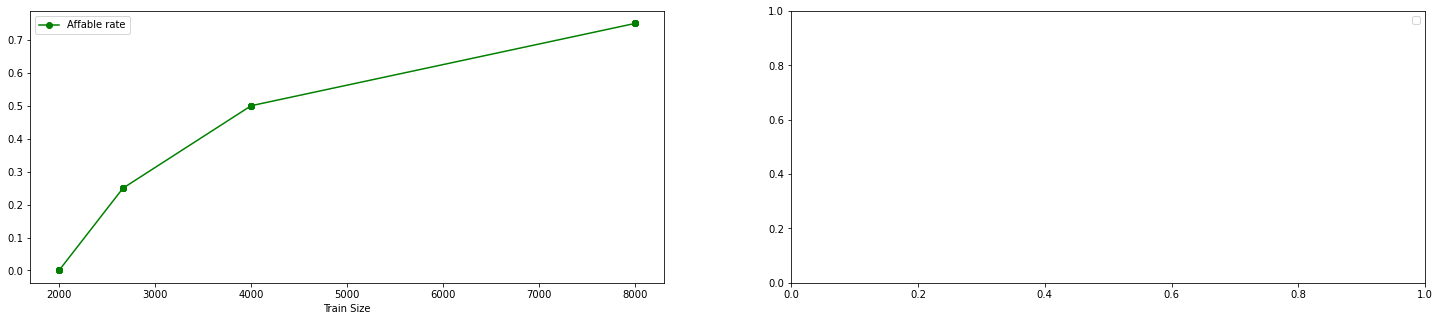

In [10]:
import warnings, matplotlib.pyplot as plt

def plot_comparison(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,2, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainAffableRate" : "Affable rate" ,
                        "TrainSize": "Train Size",
                        "Recall" : "Recall" , 
                        "F1": "F1" , 
                       }

        df[["TrainSize", "TrainAffableRate"]]\
            .rename(columns=column_renames)\
            .plot(x="Train Size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))

       
        plt.legend()

plot_comparison(df_stats)   

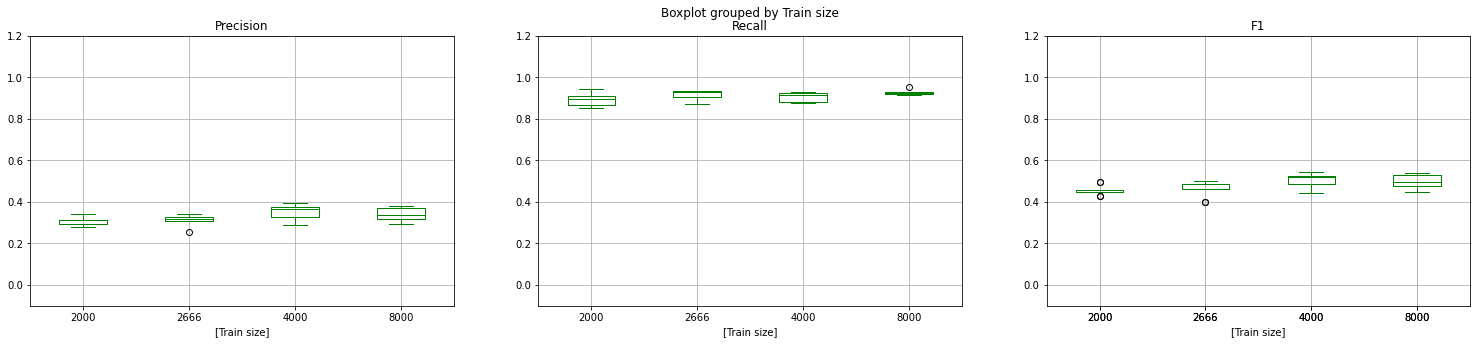

In [11]:
def plot_comparison_box(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainSize" : "Train size" ,
                        "Recall" : "Recall" , 
                        "TrainAffableRate" : "Affable rate" ,
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-0.1,1.2)
        df[["Precision", "TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[0], color="green")

        ax[1].set_ylim(-0.1,1.2)
        df[["Recall","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[1], color="green")

        ax[2].set_ylim(-0.1,1.2)
        df[["F1","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[2], color="green")

        df[["F1","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[2], color="green")

#         df[["TrainSize", "TrainAffableRate"]]\
#             .rename(columns=column_renames)\
#             .plot(x="Train size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))


    
        #plt.legend()

plot_comparison_box(df_stats)

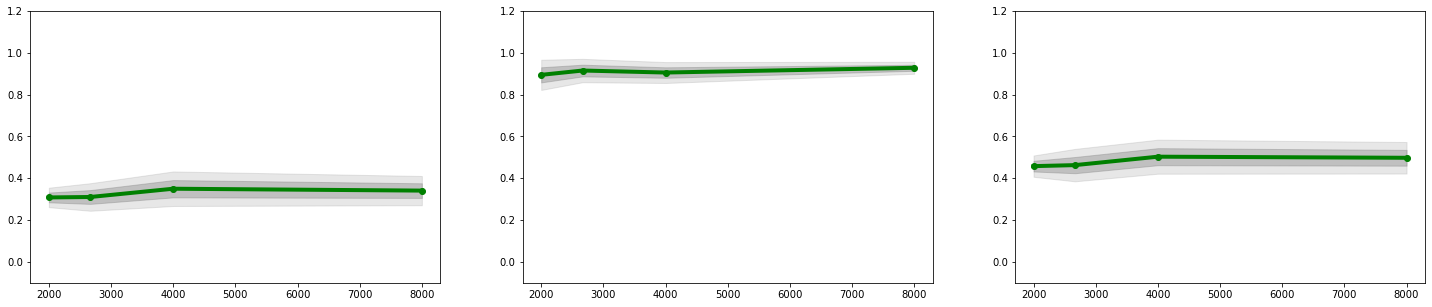

In [12]:
def plot_stdline(x, y_mean, y_std, ax, label):
    ax.plot(x, y_mean, color='green', label=label, linewidth = 4.0, marker='o')
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color='#888888', alpha=0.4)
    ax.fill_between(x, y_mean - 2*y_std, y_mean + 2*y_std, color='#888888', alpha=0.2)



def plot_comparison_linestd(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainSize" : "Train size" ,
                        "Recall" : "Recall" , 
                        "TrainAffableRate" : "Affable rate" ,
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-0.1,1.2)
        ldf = df.groupby("TrainSize")["Precision"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[0],  label='Precision')
       

        ax[1].set_ylim(-0.1,1.2)
        ldf = df.groupby("TrainSize")["Recall"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[1],  label='Recall')


        ax[2].set_ylim(-0.1,1.2)
        ldf = df.groupby("TrainSize")["F1"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[2],  label='F1')

        



#         df[["TrainSize", "TrainAffableRate"]]\
#             .rename(columns=column_renames)\
#             .plot(x="Train size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))


    
        #plt.legend()

plot_comparison_linestd(df_stats)

In [13]:
df_stats.groupby("TrainSize")[["Precision", "Recall", "F1"]].describe()



Precision                                                    \
              count      mean       std       min       25%       50%   
TrainSize                                                               
2000            5.0  0.308290  0.023262  0.279997  0.294408  0.311343   
2666            5.0  0.310405  0.032943  0.256844  0.307326  0.316157   
4000            5.0  0.349952  0.041300  0.289800  0.327691  0.363826   
8000            5.0  0.340977  0.034961  0.295659  0.320084  0.338958   

                              Recall            ...                        F1  \
                75%       max  count      mean  ...       75%       max count   
TrainSize                                       ...                             
2000       0.313767  0.341935    5.0  0.894638  ...  0.911109  0.944061   5.0   
2666       0.327632  0.344065    5.0  0.915269  ...  0.934469  0.934965   5.0   
4000       0.375064  0.393379    5.0  0.905677  ...  0.922190  0.931658   5.0   
8000       0.369307  0.380879    5.0  0.928391  ...  0.928929  0.951751   5.0   

                                                                       \
               mean       std       min       25%       50%       75%   
TrainSize                                                               
2000       0.457986  0.025467  0.426871  0.448843  0.458205  0.458757   
2666       0.462849  0.038750  0.400121  0.462596  0.463862  0.485162   
4000       0.503200  0.040715  0.441011  0.484847  0.520861  0.526346   
8000       0.497935  0.037698  0.448553  0.475846  0.495431  0.532131   

                     
                max  
TrainSize            
2000       0.497253  
2666       0.502504  
4000       0.542936  
8000       0.537714  

[4 rows x 24 columns]

In [14]:
df_stats

,Name,Precision,Recall,F1,Support,TrainSize,TrainSizePositive,TrainAffable,TrainAffableRate,PredictionsSize,PredictionsAboveThresholdSize,PredictionsAboveThresholdRatio
0,s3://aegovan-data/selfsupervised_chemprot/pred...,0.279997,0.897838,0.426871,None,2000,500,0,0.000000,500819,500819,1.0
1,s3://aegovan-data/selfsupervised_chemprot/pred...,0.313767,0.852855,0.458757,None,2000,500,0,0.000000,500819,500819,1.0
2,s3://aegovan-data/selfsupervised_chemprot/pred...,0.294408,0.944061,0.448843,None,2000,500,0,0.000000,500819,500819,1.0
3,s3://aegovan-data/selfsupervised_chemprot/pred...,0.311343,0.867325,0.458205,None,2000,500,0,0.000000,500819,500819,1.0
4,s3://aegovan-data/selfsupervised_chemprot/pred...,0.341935,0.911109,0.497253,None,2000,500,0,0.000000,500819,500819,1.0
5,s3://aegovan-data/selfsupervised_chemprot/pred...,0.344065,0.931409,0.502504,None,2666,666,666,0.249812,500819,500819,1.0
6,s3://aegovan-data/selfsupervised_chemprot/pred...,0.316157,0.870592,0.463862,None,2666,666,666,0.249812,500819,500819,1.0
7,s3://aegovan-data/selfsupervised_chemprot/pred...,0.256844,0.904908,0.400121,None,2666,666,666,0.249812,500819,500819,1.0
8,s3://aegovan-data/selfsupervised_chemprot/pred...,0.307326,0.934965,0.462596,None,2666,666,666,0.249812,500819,500819,1.0
9,s3://aegovan-data/selfsupervised_chemprot/pred...,0.327632,0.934469,0.485162,None,2666,666,666,0.249812,500819,500819,1.0


In [15]:
df_stats.groupby("TrainSize").describe().T

TrainSize                                      2000           2666  \
Precision                      count       5.000000       5.000000   
                               mean        0.308290       0.310405   
                               std         0.023262       0.032943   
                               min         0.279997       0.256844   
                               25%         0.294408       0.307326   
                               50%         0.311343       0.316157   
                               75%         0.313767       0.327632   
                               max         0.341935       0.344065   
Recall                         count       5.000000       5.000000   
                               mean        0.894638       0.915269   
                               std         0.036111       0.027931   
                               min         0.852855       0.870592   
                               25%         0.867325       0.904908   
                               50%         0.897838       0.931409   
                               75%         0.911109       0.934469   
                               max         0.944061       0.934965   
F1                             count       5.000000       5.000000   
                               mean        0.457986       0.462849   
                               std         0.025467       0.038750   
                               min         0.426871       0.400121   
                               25%         0.448843       0.462596   
                               50%         0.458205       0.463862   
                               75%         0.458757       0.485162   
                               max         0.497253       0.502504   
TrainSizePositive              count       5.000000       5.000000   
                               mean      500.000000     666.000000   
                               std         0.000000       0.000000   
                               min       500.000000     666.000000   
                               25%       500.000000     666.000000   
                               50%       500.000000     666.000000   
                               75%       500.000000     666.000000   
                               max       500.000000     666.000000   
TrainAffable                   count       5.000000       5.000000   
                               mean        0.000000     666.000000   
                               std         0.000000       0.000000   
                               min         0.000000     666.000000   
                               25%         0.000000     666.000000   
                               50%         0.000000     666.000000   
                               75%         0.000000     666.000000   
                               max         0.000000     666.000000   
TrainAffableRate               count       5.000000       5.000000   
                               mean        0.000000       0.249812   
                               std         0.000000       0.000000   
                               min         0.000000       0.249812   
                               25%         0.000000       0.249812   
                               50%         0.000000       0.249812   
                               75%         0.000000       0.249812   
                               max         0.000000       0.249812   
PredictionsSize                count       5.000000       5.000000   
                               mean   500819.000000  500819.000000   
                               std         0.000000       0.000000   
                               min    500819.000000  500819.000000   
                               25%    500819.000000  500819.000000   
                               50%    500819.000000  500819.000000   
                               75%    500819.000000  500819.000000   
                               max    500819.000000  500819.000000   
Prediction

In [16]:
from scipy import stats


 
    
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 8000")["Precision"])

Ttest_indResult(statistic=-1.7405583631628425, pvalue=0.11994254585642729)

In [17]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 8000")["Precision"])

Ttest_indResult(statistic=-1.7405583631628425, pvalue=0.11994254585642729)

In [18]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 4000")["Precision"])

Ttest_indResult(statistic=-1.965337986162084, pvalue=0.08495398871582308)

In [19]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Recall"], 
                df_stats.query("TrainSize == 8000")["Recall"])

Ttest_indResult(statistic=-1.9432799310124271, pvalue=0.08789994002746593)

In [20]:
stats.ttest_ind(df_stats.query("TrainSize == 4000")["F1"], 
                df_stats.query("TrainSize == 8000")["F1"])

Ttest_indResult(statistic=0.21217898260101234, pvalue=0.8372736360137505)